    Age : Возраст пациента
    Sex : Пол пациента (мужской = 0, женский = 1)
    exang: Стенокардия при физической нагрузке (1 = да; 0 = нет)
    ca: количество основных сосудов  (0-3)
    cp : Chest Pain: типы боли в груди
        Value 1: типичная стенокардия
        Value 2: атипичная стенокардия
        Value 3: нестенокардическая боль
        Value 4: бессимптомное состояние
    trtbps : артериальное давление в покое (в мм рт. ст.)
    chol :  холестерин в мг/дл, полученный с помощью датчика ИМТ
    fbs : (глюкоза натощак > 120 мг/дл) (1 = верно; 0 = неверно)
    rest_ecg : Электрокардиографические результаты в покое:
        Value 0: нормальные
        Value 1: наличие аномалий в зубцах ST-T (инверсии зубца Т и/или повышение или понижение ST более чем на 0,05 мВ)
        Value 2: показатель вероятного или определенного увеличения левого желудочка по критериям Эстеса

    thalach : Максимальная достигнутая частота сердечных сокращений
    oldpeak: пиковое значение
    slp: наклон
    thall: диасталического стресс-теста ~ (0,3)
    output : 0 = меньше вероятности сердечного приступа, 1 = больше вероятности сердечного приступа


In [2]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
from time import time
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv("heart.csv")

In [4]:
df.head()

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


Категориальные:  ['sex', 'exng', 'caa', 'cp', 'fbs', 'restecg', 'slp', 'thall']

Интервальные :  ['age', 'trtbps', 'chol', 'thalachh', 'oldpeak']


In [5]:
print('Кол-во строк',df.shape[0], 'кол-во столбцов ',df.shape[1])

Кол-во строк 303 кол-во столбцов  14


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trtbps    303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalachh  303 non-null    int64  
 8   exng      303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slp       303 non-null    int64  
 11  caa       303 non-null    int64  
 12  thall     303 non-null    int64  
 13  output    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


In [7]:
df[df.duplicated()]


,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
164,38,1,2,138,175,0,1,173,0,0.0,2,4,2,1


In [8]:
df.drop_duplicates(keep='first',inplace=True)


Мин, медиана, среднее, макс значения и персентили 10, 25, 75, 90 для интервальных переменных



In [9]:
df[['age', 'trtbps','chol','thalachh','oldpeak']].describe()

,age,trtbps,chol,thalachh,oldpeak
count,302.00000,302.000000,302.000000,302.000000,302.000000
mean,54.42053,131.602649,246.500000,149.569536,1.043046
std,9.04797,17.563394,51.753489,22.903527,1.161452
min,29.00000,94.000000,126.000000,71.000000,0.000000
25%,48.00000,120.000000,211.000000,133.250000,0.000000
50%,55.50000,130.000000,240.500000,152.500000,0.800000
75%,61.00000,140.000000,274.750000,166.000000,1.600000
max,77.00000,200.000000,564.000000,202.000000,6.200000


В целом у параметров средние значения и значения квартиля 50% (моды) незначительно отличаются, что может свидетельствовать о симметричности распределения данных.

Параметр chol(холестерин), thalachh(ЧСС) имеют наибольший разброс в данных.

In [10]:
print("Квантиль 0.1"'\n', df[['age', 'trtbps','chol','thalachh','oldpeak']].quantile(q=0.1))
print("Квантиль 0.9"'\n',df[['age', 'trtbps','chol','thalachh','oldpeak']].quantile(q=0.9))

Квантиль 0.1
 age          42.0
trtbps      110.0
chol        188.4
thalachh    116.0
oldpeak       0.0
Name: 0.1, dtype: float64
Квантиль 0.9
 age          66.0
trtbps      152.0
chol        308.9
thalachh    176.8
oldpeak       2.8
Name: 0.9, dtype: float64


Мода, сколько раз мода встречается в данных, уникальные значения,
наиболее повторяемое значение для каждой категориальной переменной

In [11]:
df[['age', 'trtbps', 'chol', 'thalachh', 'oldpeak']].nunique()

,0
age,41
trtbps,49
chol,152
thalachh,91
oldpeak,40


In [12]:
df[['age', 'trtbps', 'chol', 'thalachh', 'oldpeak']].mode()

,age,trtbps,chol,thalachh,oldpeak
0,58.0,120.0,197,162.0,0.0
1,NaN,NaN,204,NaN,NaN
2,NaN,NaN,234,NaN,NaN


In [13]:
corr_matrix = df[['age', 'trtbps', 'chol', 'thalachh', 'oldpeak', 'output']].corr()
corr_matrix

,age,trtbps,chol,thalachh,oldpeak,output
age,1.000000,0.283121,0.207216,-0.395235,0.206040,-0.221476
trtbps,0.283121,1.000000,0.125256,-0.048023,0.194600,-0.146269
chol,0.207216,0.125256,1.000000,-0.005308,0.050086,-0.081437
thalachh,-0.395235,-0.048023,-0.005308,1.000000,-0.342201,0.419955
oldpeak,0.206040,0.194600,0.050086,-0.342201,1.000000,-0.429146
output,-0.221476,-0.146269,-0.081437,0.419955,-0.429146,1.000000


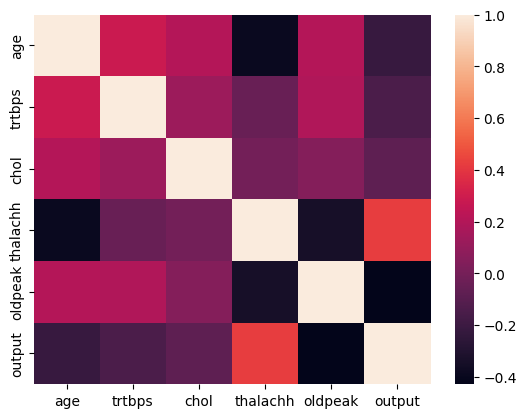

In [14]:
sns.heatmap(corr_matrix);

Согласно тепловой карте нет явной линейной корреляции между непрерывными переменными.

При этом на риск возникновения сердечного приступа наибольшее влияние оказывают величины ЧСС и

Н0: нет зависимости между ЧСС и риском возникновения сердечного приступа

Н1: существует зависимость между ЧСС и риском возникновения сердечного приступа

In [15]:
from scipy.stats import mannwhitneyu
no_heart_attack = list(df[df['output'] == 0]['thalachh'])
heart_attack = list(df[df['output'] == 1]['thalachh'])
stat, p = mannwhitneyu(no_heart_attack, heart_attack)
print('stat=%.3f, p=%.20f' % (stat, p))

stat=5725.000, p=0.00000000000013977197


p-value < 0.05 => существует статистически значимая связь между уровнем ЧСС и риском возникновения сердечного приступа. Можно сказать, что уровень ЧСС влияет на риск возникновения сердечного приступа

<Axes: xlabel='output', ylabel='oldpeak'>

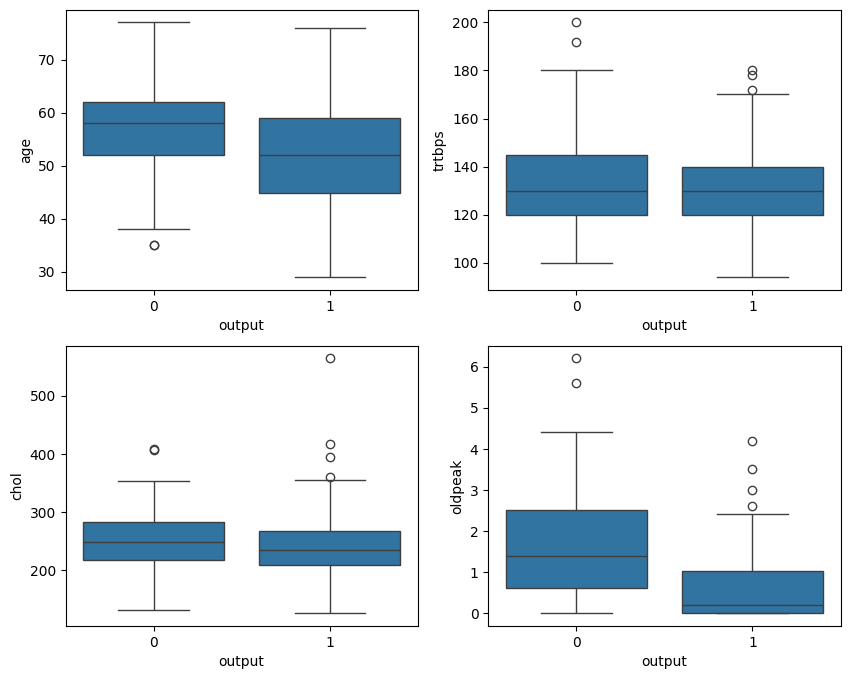

In [16]:
fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(2, 2, figsize=(10, 8))
sns.boxplot(x = 'output', y = 'age', data = df, ax=ax0)
sns.boxplot(x = 'output', y = 'trtbps', data = df, ax=ax1)
sns.boxplot(x = 'output', y = 'chol', data = df, ax=ax2)
sns.boxplot(x = 'output', y = 'oldpeak', data = df, ax=ax3)

Параметры chol и trtbps не сильно отличаются у людей с высоким риском возникновения сердечного приступа от людей с низким уровнем.

По графику можно сказать, что люди с более низким риском возникновения сердечного приступа имеют в среднем более высокий возраст, чем люди с более высоким риском


H0: Нет зависимости между уровнем холестирина и риском возникновения сердечного приступа

H1: Есть зависимость между уровнем холестеринаи и риском возникновения сердечного приступа

In [17]:
no_heart_attack = list(df[df['output'] == 0]['chol'])
heart_attack = list(df[df['output'] == 1]['chol'])
stat, p = mannwhitneyu(no_heart_attack, heart_attack)
print('stat=%.3f, p=%.3f' % (stat, p))

stat=12850.500, p=0.042


P-value < 0.05. следовательно,  при уровне значимости 0,05, существует зависимость между уровнем холестирина в крови и риском возникновения сердечного приступа



H0: Нет зависимости между уровнем артериального давления крови и риском возникновения сердечного приступа

H1: Есть зависимость между уровнем артериального давления крови и риском возникновения сердечного приступа


In [18]:
no_heart_attack = list(df[df['output'] == 0]['trtbps'])
heart_attack = list(df[df['output'] == 1]['trtbps'])
stat, p = mannwhitneyu(no_heart_attack, heart_attack)
print('stat=%.3f, p=%.3f' % (stat, p))

stat=12931.000, p=0.032


P-value < 0.05. При уровне значимости 0,05, существует зависимость между уровнем арткриального давления крови и риском возникновения сердечного приступа

<Axes: xlabel='output', ylabel='count'>

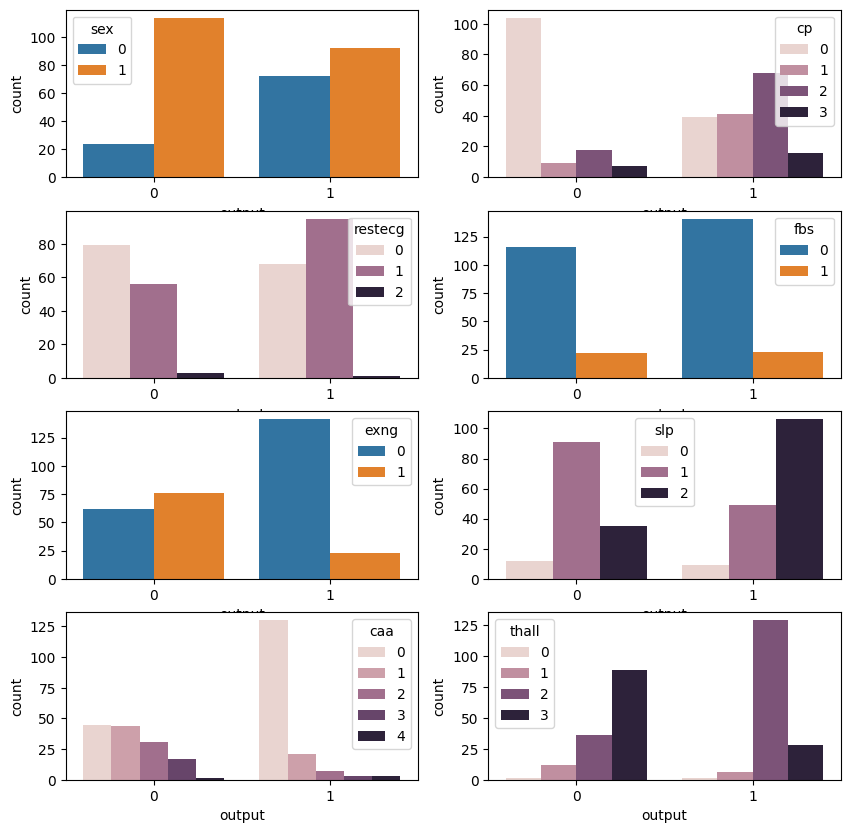

In [19]:
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(10,10))
sns.countplot(x="output", hue="sex", data=df, ax=axes[0][0])
sns.countplot(x="output", hue="cp", data=df, ax=axes[0][1])
sns.countplot(x="output", hue="restecg", data=df, ax=axes[1][0])
sns.countplot(x="output", hue="fbs", data=df, ax=axes[1][1])
sns.countplot(x="output", hue="exng", data=df, ax=axes[2][0])
sns.countplot(x="output", hue="slp", data=df, ax=axes[2][1])
sns.countplot(x="output", hue="caa", data=df, ax=axes[3][0])
sns.countplot(x="output", hue="thall", data=df, ax=axes[3][1])


Наиболее более высокий риск сердечного приступа у людей с:
                  
* Chest Pain тип Value 3: non-anginal pain
* rest_ecg : Value 1: having ST-T wave abnormality
* exng = 0
* slp = 2
* caa = 0
* thall = 2


  



Наиболее часто риск возникновения сердечного приступа возникает у людей среднего возраста (40 - 60 лет)

In [20]:
from scipy.stats import chi2_contingency
# contingency_table = pd.crosstab(df['sex'], df['output'])
contingency_table = pd.crosstab(df['fbs'], df['output'])
# Проводим тест хи-квадрат
chi2, p, dof, expected = chi2_contingency(contingency_table)

print("Хи-квадрат статистика:", chi2)
print("p-value:", p)
print("Ожидаемые частоты:")
print(expected)

Хи-квадрат статистика: 0.09240835568001494
p-value: 0.7611374700928197
Ожидаемые частоты:
[[117.43708609 139.56291391]
 [ 20.56291391  24.43708609]]


значения p-value >0.05, следовательно нет зависимости между fbs и риском возникновения сердечного приступа

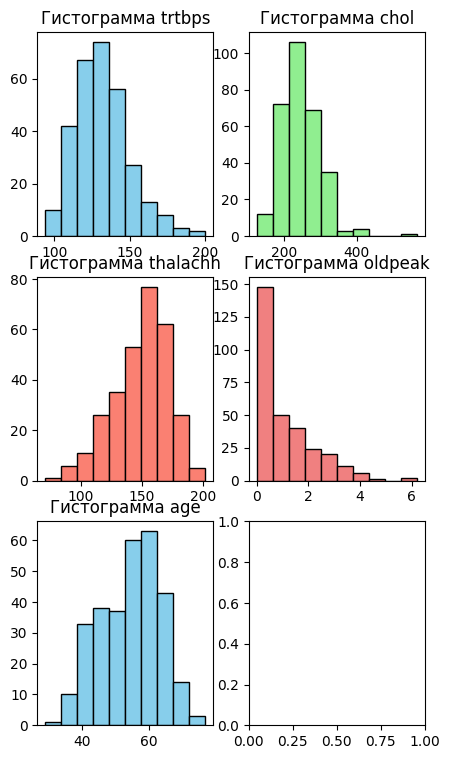

In [21]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(3, 2, figsize=(5, 9))
axs[0, 0].hist(df['trtbps'], color='skyblue', edgecolor='black')
axs[0, 0].set_title('Гистограмма trtbps')
axs[0, 1].hist(df['chol'], color='lightgreen', edgecolor='black')
axs[0, 1].set_title('Гистограмма chol')
axs[1, 0].hist(df['thalachh'], color='salmon', edgecolor='black')
axs[1, 0].set_title('Гистограмма thalachh')
axs[1, 1].hist(df['oldpeak'], color='lightcoral', edgecolor='black')
axs[1, 1].set_title('Гистограмма oldpeak')
axs[2, 0].hist(df['age'],  color='skyblue', edgecolor='black')
axs[2, 0].set_title('Гистограмма age')


plt.show()

In [22]:
df.head()

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [23]:
from sklearn.preprocessing import MinMaxScaler
column_to_scale = [3, 4, 7,9]
scaler = MinMaxScaler(feature_range=(-1, 1))

df.iloc[:,column_to_scale] = scaler.fit_transform(df.iloc[:,column_to_scale])
df.head()

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,63,1,3,-0.037736,-0.511416,1,0,0.206107,0,-0.258065,0,0,1,1
1,37,1,2,-0.320755,-0.433790,0,1,0.770992,0,0.129032,0,0,2,1
2,41,0,1,-0.320755,-0.643836,0,0,0.541985,0,-0.548387,2,0,2,1
3,56,1,1,-0.509434,-0.497717,0,1,0.633588,0,-0.741935,2,0,2,1
4,57,0,0,-0.509434,0.041096,0,1,0.404580,1,-0.806452,2,0,2,1


In [24]:
import pandas as pd
# df = df.dpop(columns = ['sex', 'fbs', 'exng', 'slp'])
# df = df.drop('sex', axis=1)
df = df.drop('fbs', axis=1)
# df = df.drop('exng', axis=1)
# df = df.drop('slp', axis=1)

In [25]:
df.head()

,age,sex,cp,trtbps,chol,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,63,1,3,-0.037736,-0.511416,0,0.206107,0,-0.258065,0,0,1,1
1,37,1,2,-0.320755,-0.433790,1,0.770992,0,0.129032,0,0,2,1
2,41,0,1,-0.320755,-0.643836,0,0.541985,0,-0.548387,2,0,2,1
3,56,1,1,-0.509434,-0.497717,1,0.633588,0,-0.741935,2,0,2,1
4,57,0,0,-0.509434,0.041096,1,0.404580,1,-0.806452,2,0,2,1


In [26]:
from sklearn.model_selection import train_test_split

x = df.drop('output', axis=1)
y = df['output']

# Разделяем данные на тренировочный и тестовый датасеты
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

In [27]:
# x_train['age_bin'] = pd.cut(x_train['age'], bins=4, labels=['age_1', 'age_2', 'age_3', 'age_4'])
# x_train['trtbps_bin'] = pd.cut(x_train['trtbps'], bins=6, labels=['trtbps_1', 'trtbps_2', 'trtbps_3', 'trtbps_4','trtbps_5', 'trtbps_6'])
# # x_train['trtbps_bin'] = pd.cut(x_train['trtbps'], bins=9, labels=['trtbps_1', 'trtbps_2', 'trtbps_3', 'trtbps_4','trtbps_5', 'trtbps_6','trtbps_7', 'trtbps_8', 'trtbps_9'])
# x_train['chol_bin'] = pd.cut(x_train['chol'], bins=4, labels=['chol_1', 'chol_2', 'chol_3', 'chol_4'])
# x_train['thalachh_bin'] = pd.cut(x_train['thalachh'], bins=6, labels=['thalachh_1', 'thalachh_2', 'thalachh_3', 'thalachh_4','thalachh_5', 'thalachh_6'])
# x_train['oldpeak_bin'] = pd.cut(x_train['oldpeak'], bins=4, labels=['oldpeak_1', 'oldpeak_2', 'oldpeak_3', 'oldpeak_4'])

# # Применение get_dummies к бинам
# x_train = pd.get_dummies(x_train[['sex', 'exng', 'caa', 'cp', 'fbs', 'restecg', 'slp', 'thall', 'age_bin', 'trtbps_bin', 'chol_bin', 'thalachh_bin', 'oldpeak_bin']])
# # x_train = pd.get_dummies(x_train[['sex', 'exng', 'caa', 'cp', 'fbs', 'restecg', 'slp', 'thall', 'age_bin', 'trtbps_bin', 'thalachh_bin']])
# x_train.head()

In [28]:
# x_test['age_bin'] = pd.cut(x_test['age'], bins=4, labels=['age_1', 'age_2', 'age_3', 'age_4'])
# x_test['trtbps_bin'] = pd.cut(x_test['trtbps'], bins=6, labels=['trtbps_1', 'trtbps_2', 'trtbps_3', 'trtbps_4','trtbps_5', 'trtbps_6'])
# # x_test['trtbps_bin'] = pd.cut(x_test['trtbps'], bins=9, labels=['trtbps_1', 'trtbps_2', 'trtbps_3', 'trtbps_4','trtbps_5', 'trtbps_6','trtbps_7', 'trtbps_8', 'trtbps_9'])
# x_test['chol_bin'] = pd.cut(x_test['chol'], bins=4, labels=['chol_1', 'chol_2', 'chol_3', 'chol_4'])
# x_test['thalachh_bin'] = pd.cut(x_test['thalachh'], bins=6, labels=['thalachh_1', 'thalachh_2', 'thalachh_3', 'thalachh_4','thalachh_5', 'thalachh_6'])
# x_test['oldpeak_bin'] = pd.cut(x_test['oldpeak'], bins=4, labels=['oldpeak_1', 'oldpeak_2', 'oldpeak_3', 'oldpeak_4'])

# # Применение get_dummies к бинам

# x_test = pd.get_dummies(x_test[['sex', 'exng', 'caa', 'cp', 'fbs', 'restecg', 'slp', 'thall', 'age_bin', 'trtbps_bin', 'chol_bin', 'thalachh_bin', 'oldpeak_bin']])
# # x_test = pd.get_dummies(x_test[['sex', 'exng', 'caa', 'cp', 'fbs', 'restecg', 'slp', 'thall', 'age_bin', 'trtbps_bin', 'thalachh_bin']])
# x_test.head()

In [29]:
x_train.head()

,age,sex,cp,trtbps,chol,restecg,thalachh,exng,oldpeak,slp,caa,thall
74,43,0,2,-0.471698,-0.602740,1,0.435115,0,-0.935484,1,0,2
153,66,0,2,-0.018868,-0.305936,0,0.236641,0,-1.000000,1,1,2
64,58,1,2,-0.132075,-0.611872,0,0.435115,0,-1.000000,2,0,2
296,63,0,0,-0.433962,-0.675799,1,-0.007634,1,-1.000000,1,0,2
288,57,1,0,-0.698113,-0.045662,1,0.099237,1,-0.032258,1,1,3


In [30]:
# X= x_train.drop(columns='output')
X = x_train
Y = y_train
# Y = y_train['output']

skf = StratifiedKFold(n_splits=4)
for train_index, test_index in skf.split(X, Y):
    X_tr, X_val = X.iloc[train_index], X.iloc[test_index]
    Y_tr, Y_val = Y.iloc[train_index], Y.iloc[test_index]
    print('Train & Validation sets built.')
    break

Train & Validation sets built.


In [31]:
# Определить обобщенную функцию для оценки текущего экземпляра модели и данных
'''
возвращает :: a) acc: точность, вычисленная на валидационном наборе
             б) exec_time: время сборки / подгонки модели
'''
def evaluate(X_tr, Y_tr, X_val, Y_val, params):
    model = LogisticRegression()
    # Мы должны использовать set_params для передачи параметров объекту модели.
    # Это имеет преимущество перед использованием setattr в том, что он позволяет Scikit научиться выполнять некоторые проверки правильности параметров.
    model.set_params(**params)

    start=time()
    model.fit(X_tr,Y_tr)
    exec_time = time() - start

    Y_pred = model.predict(X_val)
    acc = accuracy_score(Y_val,Y_pred) * 100.0
    return acc, exec_time

In [32]:
C=0.001
iterations = 500
results = np.zeros((iterations, 5))

for i in range(0,iterations):
    model_params = {'C':C,'random_state':1}
    acc_val,time_val = evaluate(X_tr, Y_tr, X_val, Y_val, model_params)
    acc_tr,time_tr = evaluate(X_tr, Y_tr, X_tr, Y_tr, model_params)
    results[i] = i+1, C, acc_tr, acc_val, time_val
    C+=0.005

res_df = pd.DataFrame(  data=results[0:,0:],
                        index=results[0:,0],
                        columns=['Sl','C','Train_acc','Val_acc','Build_time'])
res_df['Sl'] = res_df['Sl'].astype(np.uint16)
print(res_df[res_df['Val_acc'] == res_df['Val_acc'].max()])
#res_df.head()

Выходные данные были обрезаны до нескольких последних строк (5000).
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/

     Sl      C  Train_acc    Val_acc  Build_time
5.0   5  0.021       80.0  83.606557    0.009569
6.0   6  0.026       80.0  83.606557    0.010782
7.0   7  0.031       80.0  83.606557    0.013179


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Значение параметра C выбираем равное 0,021, т.к при этом значении точность максимальна и занимаем наименьшее время

In [33]:

from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score


# Создадим модель логистической регрессии
# model = LogisticRegression()
model = LogisticRegression(tol = 0.0001, C = 0.021, max_iter = 100, solver = 'sag')
# model = LogisticRegression(tol = 0.0001, C = 1, solver = 'sag', max_iter = 200)
# Обучим модель на обучающем наборе данных
model.fit(x_train, y_train)

# Сделаем прогноз на тестовом наборе данных
y_pred = model.predict(x_test)

# Оценим точность модели
accuracy = accuracy_score(y_test, y_pred)
print(f"Точность модели: {accuracy}")

Точность модели: 0.8524590163934426


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


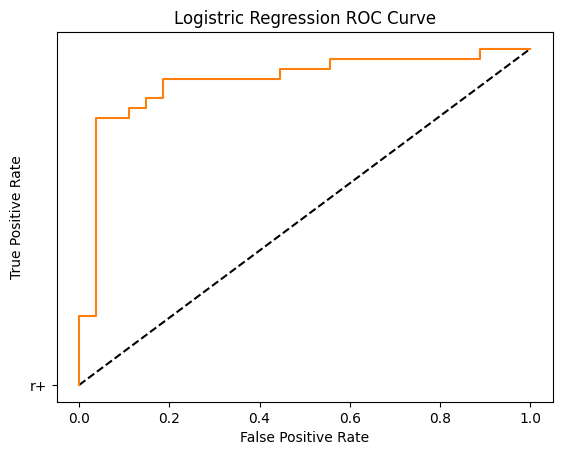

In [34]:
from sklearn.metrics import roc_curve, auc
y_pred= model.predict_proba(x_test)[:,1]

fpr,tpr,threshols=roc_curve(y_test,y_pred)

# plotting the curve
plt.plot([0,1],[0,1],"k--",'r+')
plt.plot(fpr,tpr,label='Logistic Regression')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Logistric Regression ROC Curve")
plt.show()



In [35]:
from sklearn.metrics import roc_auc_score

auc = roc_auc_score(y_test, y_pred)
print(auc)

0.9041394335511983


Дерево решений

In [36]:
from sklearn.tree import DecisionTreeClassifier


def evaluate(X_tr, Y_tr, X_val, Y_val, params):
    model = DecisionTreeClassifier()
    # Мы должны использовать set_params для передачи параметров объекту модели.
    # Это имеет преимущество перед использованием setattr в том, что он позволяет Scikit научиться выполнять некоторые проверки правильности параметров.
    model.set_params(**params)

    start=time()
    model.fit(X_tr,Y_tr)
    exec_time = time() - start

    Y_pred = model.predict(X_val)
    acc = accuracy_score(Y_val,Y_pred) * 100.0
    return acc, exec_time

In [37]:
model = DecisionTreeClassifier()
max_depth=2,
min_samples_split=2
model.set_params(**{'max_depth':max_depth,'min_samples_split':min_samples_split})

DecisionTreeClassifier(max_depth=(2,))

In [38]:

max_depth = 2
min_samples_split=2
iterations = 200
results = np.zeros((iterations, 6))

for i in range(0,iterations):
    model_params = {'max_depth': max_depth, 'min_samples_split':min_samples_split}
    acc_val,time_val = evaluate(X_tr, Y_tr, X_val, Y_val, model_params)
    acc_tr,time_tr = evaluate(X_tr, Y_tr, X_tr, Y_tr, model_params)
    results[i] = i+1, max_depth, min_samples_split , acc_tr, acc_val, time_val
    max_depth+=1
    min_samples_split+=2


res_df_tol = pd.DataFrame(  data=results[0:,0:],
                        index=results[0:,0],
                        columns=['Sl','max_depth','min_samples_split','Train_acc','Val_acc','Build_time'])
res_df_tol['Sl'] = res_df['Sl'].astype(np.uint16)
res_df_tol.head()

,Sl,max_depth,min_samples_split,Train_acc,Val_acc,Build_time
1.0,1,2.0,2.0,77.777778,75.409836,0.002943
2.0,2,3.0,4.0,86.666667,67.213115,0.002295
3.0,3,4.0,6.0,90.000000,67.213115,0.002089
4.0,4,5.0,8.0,92.222222,68.852459,0.002795
5.0,5,6.0,10.0,91.666667,67.213115,0.003752


Максимальную глубину выбираем 4? 6

In [39]:

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
# from sklearn.metrics import accuracy_score
model_2= DecisionTreeClassifier( max_depth=4, min_samples_split=6)
# model_2= DecisionTreeClassifier()
model_2.fit(x_train, y_train)
y_pred2 = model_2.predict(x_test)
accuracy_2 = accuracy_score(y_test, y_pred2)
print(f"Accuracy: {accuracy_2}")

Accuracy: 0.8360655737704918


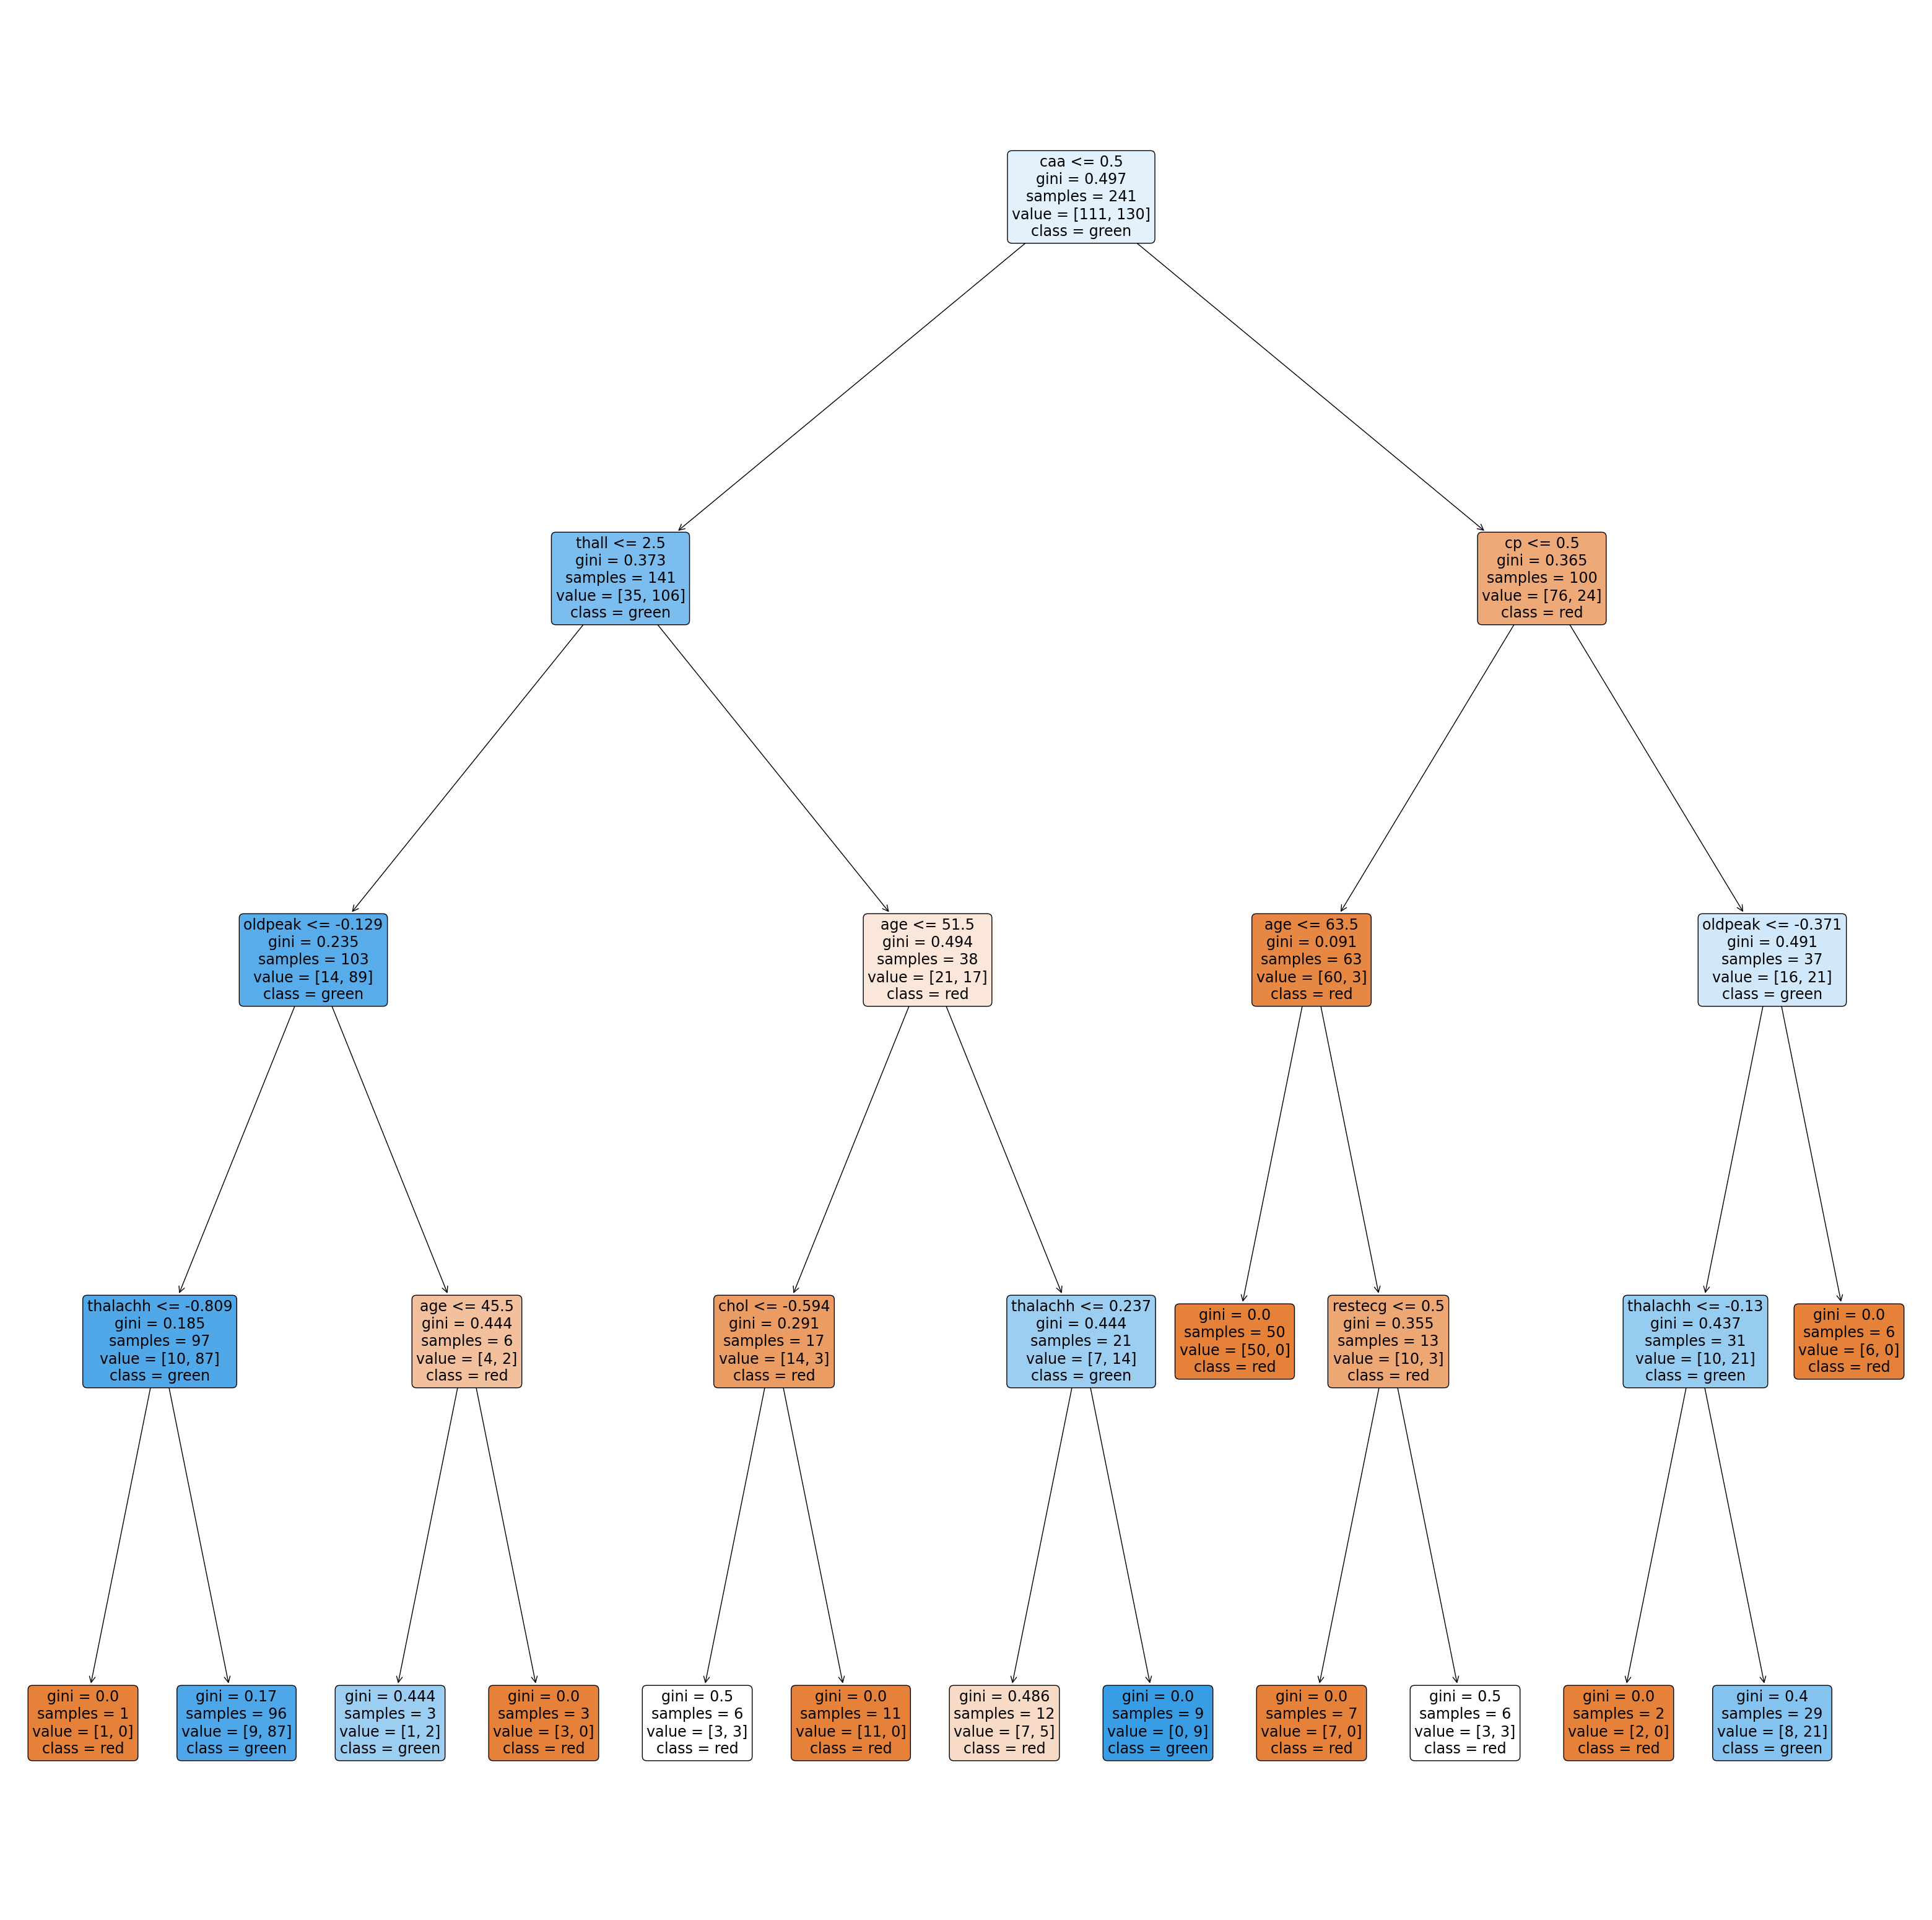

In [40]:
from sklearn import tree
import matplotlib.pyplot as plt

# Визуализация дерева
plt.figure(figsize=(40,40))
tree.plot_tree(model_2, feature_names=X_tr.columns, class_names=["red", "green"], filled=True, rounded=True)
plt.show()

In [41]:
from sklearn.svm import SVC

model_3 = SVC(C = 1)
model_3.fit(x_train, y_train)


y_pred3 = model_3.predict(x_test)
accuracy_3 = accuracy_score(y_test, y_pred3)
print(f"Accuracy: {accuracy_3}")


Accuracy: 0.7377049180327869


При построении модели логистической регресии точность модели составила 85%

дерева решений - 81%

Для улучшения точности неоьходимо изменить параметры моделей (возможно убрать некоторые признаки из выборки и тд)

